# Deskripsi library yang digunakan

In [2]:
import pandas as pd
import numpy as np

#library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#library untuk analisis data time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Memanggil dataset

In [3]:
df = pd.read_excel("CO2 dataset.xlsx")
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


# Transform data

In [5]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [6]:
df.set_index(['Year'], inplace=True)

In [7]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [8]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [9]:
#cek apakah data dari dataset bersifat continuos 
if(df.index.max() - df.index.min() == 214):
    print('Data is continous')

In [10]:
#Setting data frequenzy pertahun
df.index.freq = 'YS'

# Analisa time series

<AxesSubplot:xlabel='Year'>

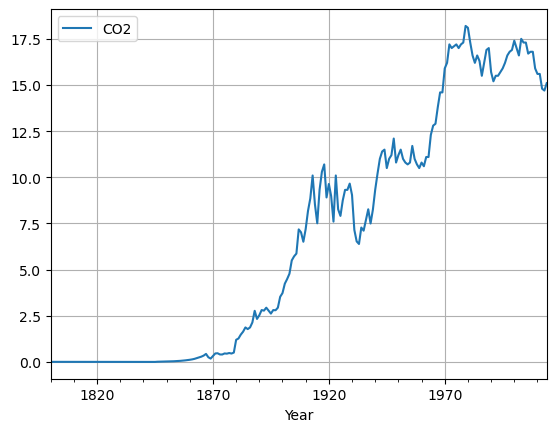

In [11]:
df.plot(grid=True)

In [12]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

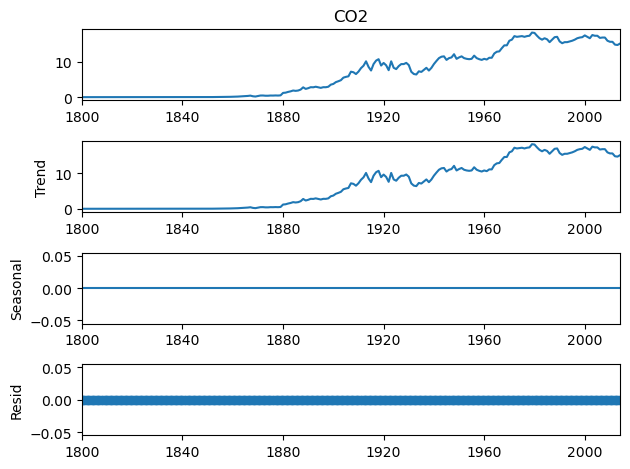

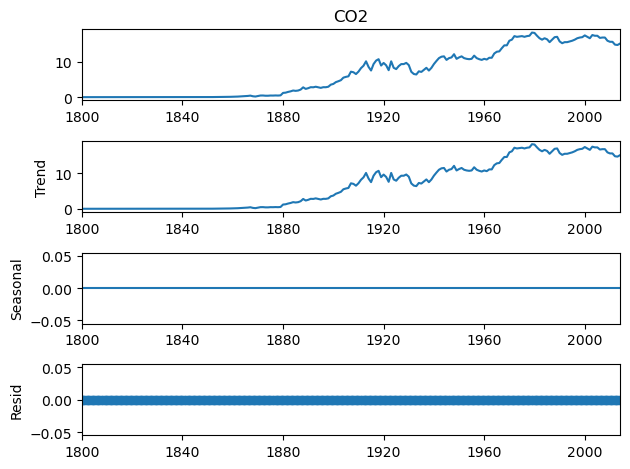

In [13]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [14]:
def adf_test(timeseries):
    print('Hasil testing Dickey-Fullen')
    print('--------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic', 'p-value', 'Lags Used', 'Number of Observation Used'])
    for key, Value in adftest[4].items():
        adf_output['Critical Value (%s)' %key] = Value
    print(adf_output)

adf_test(df.values)

Hasil testing Dickey-Fullen
--------------------------------
Test statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number of Observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [15]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [16]:
# untuk depending beberapa value yang berbeda atau dari yan null
diff_df.dropna(inplace=True)

<AxesSubplot:xlabel='Year'>

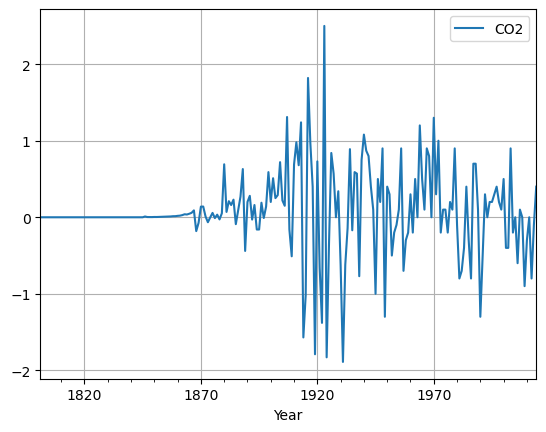

In [17]:
diff_df.plot(grid=True)

jika dilihat gambar cukup stasioner

In [18]:
adf_test(diff_df)

Hasil testing Dickey-Fullen
--------------------------------
Test statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number of Observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


Lalu kita coba buatkan satu plot lagi yaitu parsial auto correlation sama yang untuk auto correlation

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


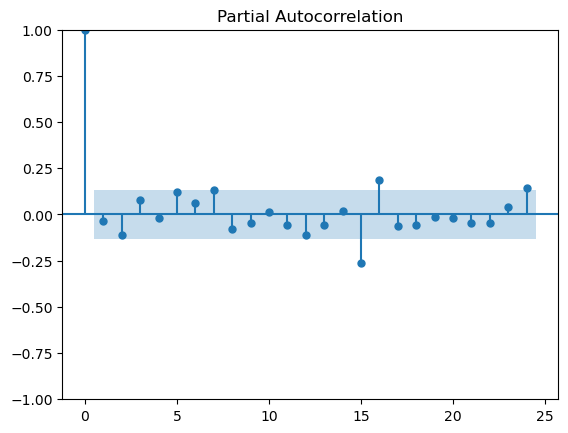

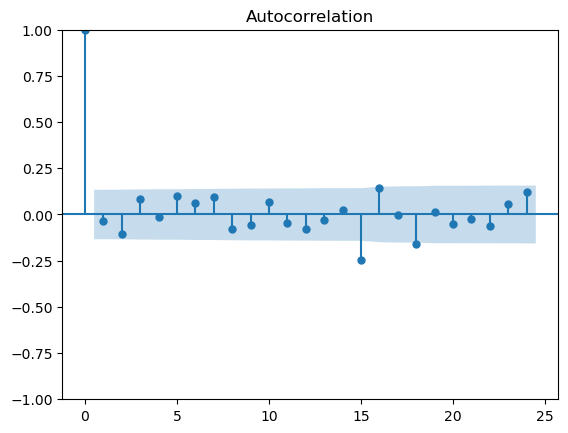

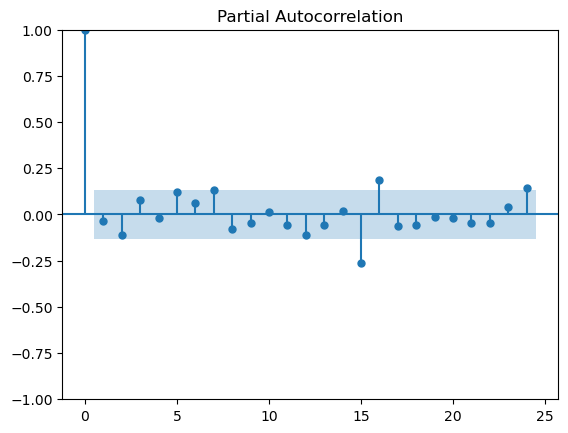

In [19]:
plot_acf(diff_df)
plot_pacf(diff_df)

jika dilihat pengukuran diatas, data sudah bersifat staisioner

# Single Exponential Smoothing

In [20]:
single_exp  = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

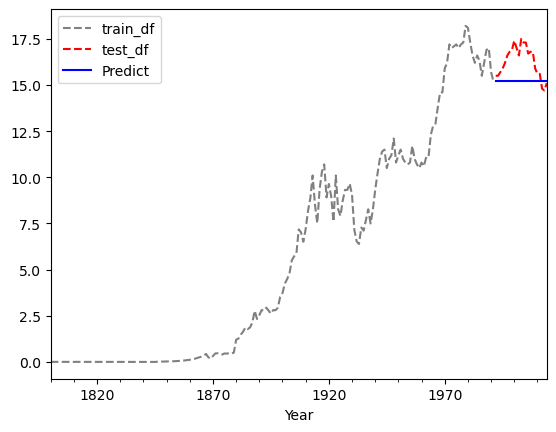

In [21]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--',color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Predict')

In [22]:
print('Train RSME :', mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RSME: ', mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE: ', mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Tets MAPE: ', mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RSME : 0.5646920026800415
Test RSME:  1.3429113036195488
Train MAPE:  0.08470516062079891
Tets MAPE:  0.0686146641963199


# Double Exponential Smoothing

In [27]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

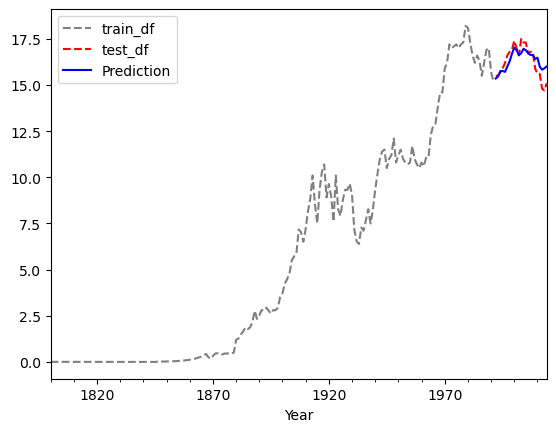

In [28]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [29]:
print('Train RMSE : ', mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RSME : ', mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE : ', mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test Mape : ', mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE :  0.521996305282245
Test RSME :  0.5352721607049857
Train MAPE :  12.806766098061516
Test Mape :  0.026063824248482872


# ARIMA

In [30]:
ar = ARIMA(train_df, order=(15, 1, 15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Year'>

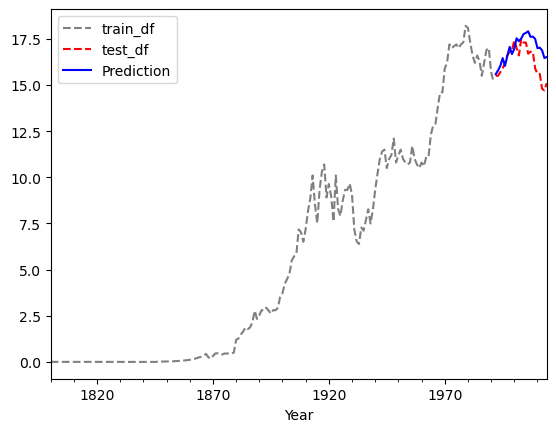

In [31]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--',color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [32]:
print('Train RMSE : ', mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RSME : ', mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE : ', mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test Mape : ', mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE :  0.4678084778578248
Test RSME :  0.9549934124787904
Train MAPE :  0.0814497259432942
Test Mape :  0.04728456013473657


# Perbandingan Algortima

In [34]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', 1.3429, 0.0686],
    ['Double Exp Smoothing', 0.5352, 0.0260],
    ['ARIMA', 0.9549, 0.0472]
    ],
    columns=['Model', 'RSME', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [35]:
comparision_df.sort_values(by='RSME')

,RSME,MAPE
Model,,
Double Exp Smoothing,0.5352,0.0260
ARIMA,0.9549,0.0472
Single Exp Smoothing,1.3429,0.0686


In [39]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20)

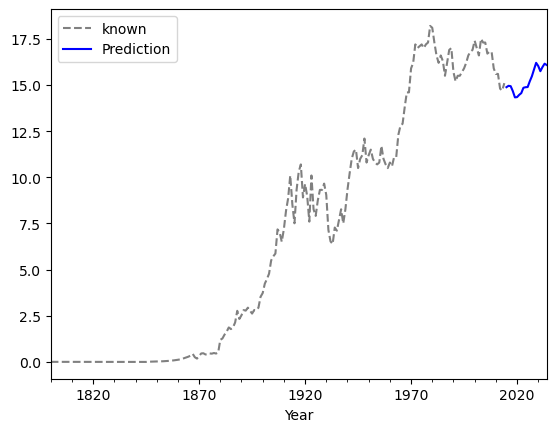

In [40]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')#dari 1800-2014
double_exp_pred.plot(color='b', legend=True, label='Prediction')# ini prediksi 20 tahun kedepan
plt.show()

In [37]:
import pickle

In [38]:
pickle.dump(double_exp, open('prediksi_co2.sav', 'wb'))